# Sunspot number prediction - monthly data

This is an example of time series modeling. The data used is the SILSO sunspot number, from the Royal Observatory of Belgium, Brussels (<http://sidc.be/silso/home>).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import geoml

The data comes as the total daily count, monthly and yearly averages. Refer to the website for detailed information about the data.

In [2]:
yearly, monthly, daily = geoml.data.Examples.sunspot_number()

In [3]:
monthly

Object of class Points1D with 3242 data locations

Data preview:

   year  month  year_frac     sn  sn_std  n_obs  definitive
0  1749      1   1749.042   96.7    -1.0     -1           1
1  1749      2   1749.123  104.3    -1.0     -1           1
2  1749      3   1749.204  116.7    -1.0     -1           1
3  1749      4   1749.288   92.8    -1.0     -1           1
4  1749      5   1749.371  141.7    -1.0     -1           1

## Model training

We will use the spectral mixture kernel (Wilson and Adams, 2013). It can be reproduced here by specifiying a product between a cosine kernel and a Gaussian. We add 5 such kernels to catch low- and high-frequency patterns.

The sunspot number must be positive, so we use a softplus warping to ensure positivity and a spline warping to handle an anisotropic data distribution.

In [16]:
# A nested list specifies the product.
kernels = [[geoml.kernels.ExponentialKernel(geoml.transform.Isotropic(10)),
           geoml.kernels.CosineKernel(geoml.transform.Isotropic(20))] for _ in range(5)]

# Warpings are applied to the data in order.
warping = [geoml.warping.Softplus(), 
           geoml.warping.Spline(n_knots=5)]

gp = geoml.models.GP(monthly, variable="sn", kernels=kernels, warping=warping)

# Setting the parameter limits. Minimum range and period are set to the Nyquist period.
for i in range(5):
    gp.cov_model.set_kernel_parameter_limits([i, 0], "range", 2, 6000)
    gp.cov_model.set_kernel_parameter_limits([i, 1], "range", 2, 6000)

gp.train(seed=1234, max_iter=10000, mut_prob=0.5, stopping=5000)

Initializing population..................................................

Iteration: 10000 | Best fitness: -14120.76597440918 | No improvement for 186/5000 iterations         

The trained model. The parameter "range" in the `CosineKernel` object actually represents the wave's period. The `ExponentialKernel`'s range determines how far in time the pattern persists, while the variance represents the pattern's contribution to the overall variance of the data.

It can be seen that there is a strong contribution from a pattern with period between 10-11 years, and a smaller one with period of 108 years.

In [17]:
print(gp)

A GP object

Covariance model: A CovarianceModelRegression object

Variance is free

Nugget: 0.004183924760791995

Position 0: variance = 0.012849807958719796

	Position [0][0]: ExponentialKernel
		range: [3.21640626] (free)

	Position [0][1]: CosineKernel
		range: [10.95570359] (free)

Position 1: variance = 0.7965271420440487

	Position [1][0]: ExponentialKernel
		range: [5121.45662749] (free)

	Position [1][1]: CosineKernel
		range: [128.36282097] (free)

Position 2: variance = 0.008484123314820551

	Position [2][0]: ExponentialKernel
		range: [223.14820771] (free)

	Position [2][1]: CosineKernel
		range: [119.65337182] (free)

Position 3: variance = 0.03245845608713237

	Position [3][0]: ExponentialKernel
		range: [5616.31154851] (free)

	Position [3][1]: CosineKernel
		range: [1922.52925936] (free)

Position 4: variance = 0.14549654583448665

	Position [4][0]: ExponentialKernel
		range: [4989.51322275] (free)

	Position [4][1]: CosineKernel
		range: [1534.73502173] (free)

Warping

## Prediction

Let us make a prediction up to year 2050.

In [18]:
grid = geoml.data.Grid1D(start=2500, n=1180, step=1)  # geoml.data.Grid1D(start=3241, n=385, step=1)

gp.predict(grid, verbose=False)
print(grid)

Object of class Grid1D with 1180 data locations

Data preview:

    sn_mean  sn_variance     ...        sn_p0.75   sn_p0.975
0  0.796627     0.007308     ...      260.302824  289.340335
1  0.775748     0.007308     ...      255.079611  283.538856
2  0.917105     0.007308     ...      292.329368  339.195647
3  0.867941     0.007308     ...      278.741795  312.323759
4  0.767475     0.007308     ...      253.024924  281.281585

[5 rows x 7 columns]


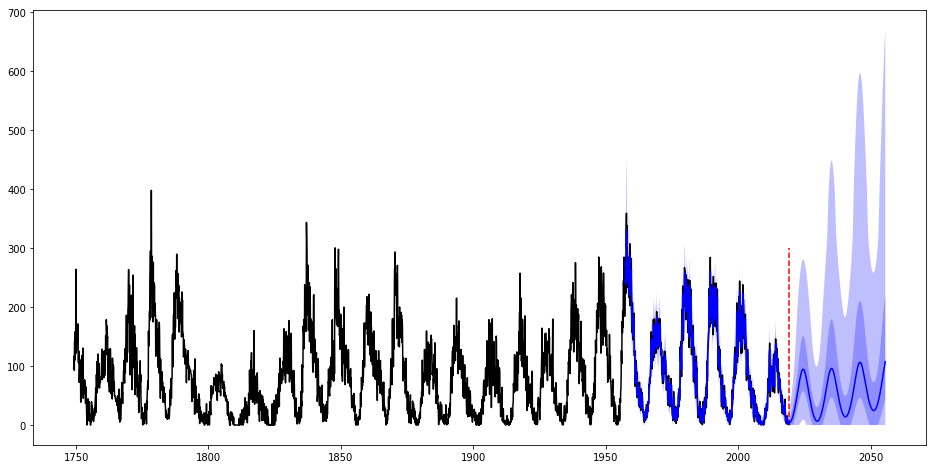

In [19]:
plt.figure(figsize=(16,8))
plt.plot(monthly.coords/12 + 1749, monthly.data["sn"].values, "k-")
plt.fill_between(np.squeeze(grid.coords)/12 + 1749, grid.data["sn_p0.975"].values, grid.data["sn_p0.025"].values,
                 facecolor="blue", alpha=0.25)
plt.fill_between(np.squeeze(grid.coords)/12 + 1749, grid.data["sn_p0.75"].values, grid.data["sn_p0.25"].values,
                 facecolor="blue", alpha=0.25)
plt.plot(np.array([3241/12 + 1749, 3241/12 + 1749]), np.array([0, 300]), "r--")
plt.plot(grid.coords/12 + 1749, grid.data["sn_p0.5"].values, "b-")
plt.show()

A closer look at the prediction:

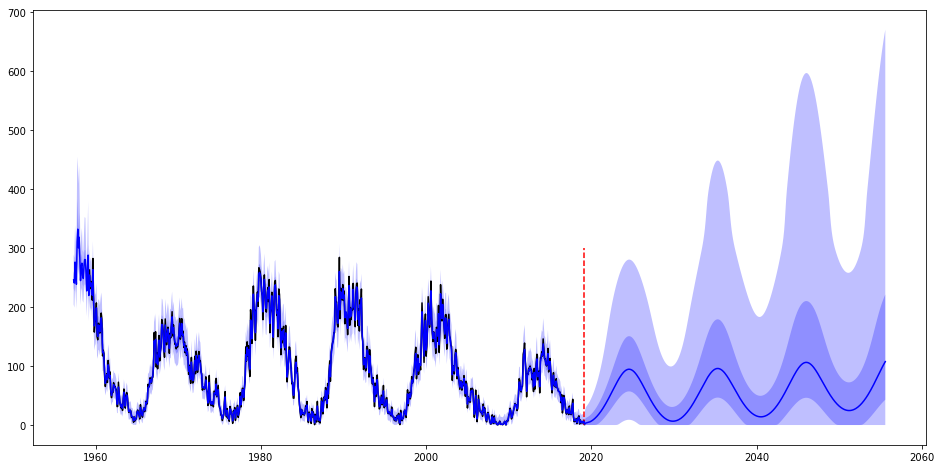

In [21]:
plt.figure(figsize=(16,8))
plt.fill_between(np.squeeze(grid.coords)/12 + 1749, grid.data["sn_p0.975"].values, grid.data["sn_p0.025"].values,
                 facecolor="blue", alpha=0.25)
plt.fill_between(np.squeeze(grid.coords)/12 + 1749, grid.data["sn_p0.75"].values, grid.data["sn_p0.25"].values,
                 facecolor="blue", alpha=0.25)
plt.plot(monthly.coords[-720:]/12 + 1749, monthly.data["sn"].values[-720:], "k-")
plt.plot(np.array([3241/12 + 1749, 3241/12 + 1749]), np.array([0, 300]), "r--")
plt.plot(grid.coords/12 + 1749, grid.data["sn_p0.5"].values, "b-")
plt.show()

The blue line is the median of the predictive distribution, while the ribbons mark the 95% confidence interval and interquartile range. The dashed line marks the limit of the training data. See how the warping prevents negative predictions, and makes the predictive distribution asymmetric.

## References

Rasmussen, C. E., & Williams, C. K. I. (2006). Gaussian processes for machine learning. Cambridge, Massachusetts: MIT Press. https://doi.org/10.1142/S0129065704001899

Snelson, E., Rasmussen, C. E., & Ghahramani, Z. (2004). Warped Gaussian processes. Adv Neural Inf Process Syst 16, 16, 337–344.

Wilson, A. G., & Adams, R. P. (2013). Gaussian Process Kernels for Pattern Discovery and Extrapolation. In 30th International Conference on Machine Learning (Vol. 28, pp. 1067–1075). Atlanta. Retrieved from http://arxiv.org/abs/1302.4245